### Basic ResNet implementation on Pets
* Load and visualize data
* Build multi layer CNN
* Build ResNet

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 32

In [3]:
path = untar_data(URLs.MNIST)
il = ImageList.from_folder(path, convert_mode='L')
sd = il.split_by_folder(train='training', valid='testing')
ll = sd.label_from_folder()
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])
ll = ll.transform(tfms)
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [4]:
data.c

10

In [5]:
gc.collect()

394

2


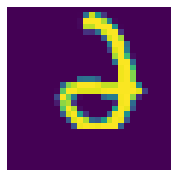

In [6]:
x,y = data.train_ds[0]
x.show()
print(y)

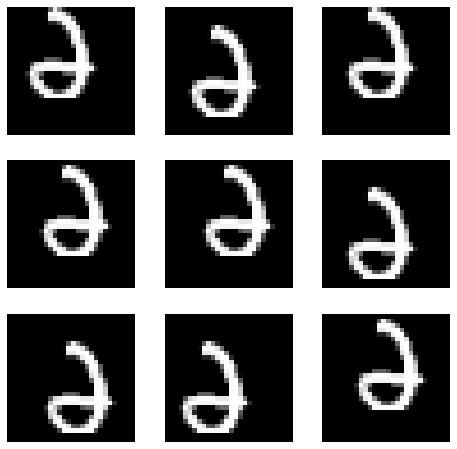

In [7]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

### Basic sequential model

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 16, 3, stride = 2, padding=1), #14
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, stride = 2, padding=1), # 7
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, stride = 2, padding=1), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, 16, 3, stride = 2, padding=1), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 10, 3, stride = 2, padding=1), # 2
    nn.BatchNorm2d(10),
    nn.Flatten()
)

In [9]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [11]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         160        True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           4,640      True      
______________________________________________________________________
BatchNorm2d          [32, 7, 7]           64         True      
______________________________________________________________________
ReLU                 [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           9,248      True      
___________________________________________________

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


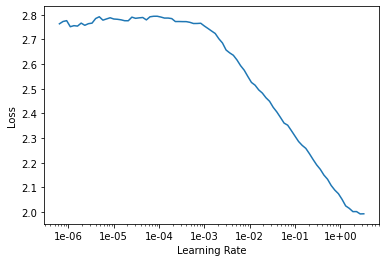

In [13]:
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(3, max_lr = 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.276680,0.174136,0.945300,00:11
1,0.193958,0.103106,0.969300,00:11
2,0.094461,0.039500,0.988200,00:11


### pre-written convs

In [15]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [16]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [17]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


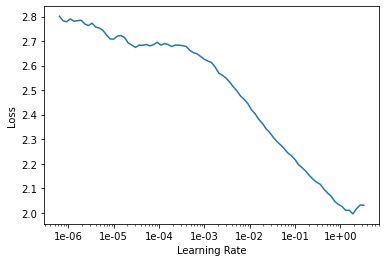

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(3, max_lr = 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.293881,0.144403,0.955100,00:11
1,0.176382,0.121897,0.962900,00:11
2,0.099209,0.045761,0.985700,00:11


### Custom module

In [83]:
class BasicConvs_fai(nn.Module):
    def __init__(self, ni ,no):
        super().__init__()
        self.conv1 = conv2d(ni, 16, stride=2)
        self.conv2 = conv2d(16, 32, stride=2)
        self.conv3 = conv2d(32, 64, stride=2)
        self.conv4 = conv2d(64, 32, stride=2)
        self.conv5 = conv2d(32, no, stride=2)
        self.bn1 = batchnorm_2d(16)
        self.bn2 = batchnorm_2d(32)
        self.bn3 = batchnorm_2d(64)
        self.bn4 = batchnorm_2d(32)
        self.bn5 = batchnorm_2d(no)
        self.relu = relu()
        self.flat = nn.Flatten()

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = self.bn1(xb)
        xb = self.relu(xb)
        xb = self.conv2(xb)
        xb = self.bn2(xb)
        xb = self.relu(xb)
        xb = self.conv3(xb)
        xb = self.bn3(xb)
        xb = self.relu(xb)
        xb = self.conv4(xb)
        xb = self.bn4(xb)
        xb = self.relu(xb)
        xb = self.conv5(xb)
        xb = self.bn5(xb)
        xb = self.relu(xb)
        xb = self.flat(xb)
        return xb

In [84]:
base_model = BasicConvs_fai(1, 10)

In [85]:
learn = Learner(data, base_model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [87]:
learn.summary()

BasicConvs
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         144        True      
______________________________________________________________________
Conv2d               [32, 7, 7]           4,608      True      
______________________________________________________________________
Conv2d               [64, 4, 4]           18,432     True      
______________________________________________________________________
Conv2d               [32, 2, 2]           18,432     True      
______________________________________________________________________
Conv2d               [10, 1, 1]           2,880      True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
BatchNorm2d          [32, 7, 7]           64         True      
___________________________________________________

In [88]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


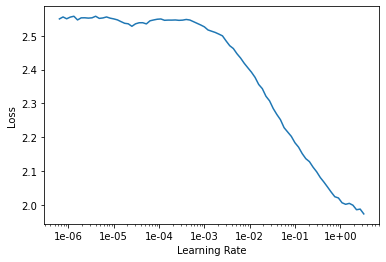

In [89]:
learn.recorder.plot()

In [90]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.266321,0.224341,0.933700,00:10
1,0.162190,0.092365,0.972800,00:10
2,0.075419,0.034452,0.990300,00:10


In [98]:
class BasicConvs_pyt(nn.Module):
    def __init__(self, ni ,no):
        super().__init__()
        self.conv1 = nn.Conv2d(ni, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(32, no, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(no)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.relu5 = nn.ReLU()
        self.flat = nn.Flatten()

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = self.bn1(xb)
        xb = self.relu1(xb)
        xb = self.conv2(xb)
        xb = self.bn2(xb)
        xb = self.relu2(xb)
        xb = self.conv3(xb)
        xb = self.bn3(xb)
        xb = self.relu3(xb)
        xb = self.conv4(xb)
        xb = self.bn4(xb)
        xb = self.relu4(xb)
        xb = self.conv5(xb)
        xb = self.bn5(xb)
        xb = self.relu5(xb)
        xb = self.flat(xb)
        return xb

In [99]:
base_model2 = BasicConvs_pyt(1, 10)

In [100]:
learn = Learner(data, base_model2, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [101]:
learn.summary()

BasicConvs_pyt
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         160        True      
______________________________________________________________________
Conv2d               [32, 7, 7]           4,640      True      
______________________________________________________________________
Conv2d               [64, 4, 4]           18,496     True      
______________________________________________________________________
Conv2d               [32, 2, 2]           18,464     True      
______________________________________________________________________
Conv2d               [10, 1, 1]           2,890      True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
BatchNorm2d          [32, 7, 7]           64         True      
_______________________________________________

In [102]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


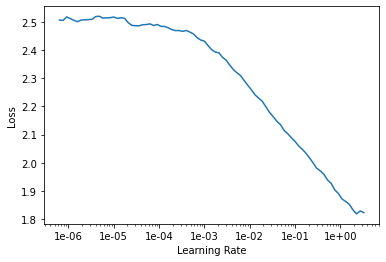

In [103]:
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.297080,0.172401,0.946100,00:11
1,0.162000,0.104019,0.969200,00:11
2,0.076979,0.036633,0.988000,00:11


In [136]:
def seq_conv_bn_relu(ni, no, s=2):
    return nn.Sequential(
        conv2d(ni, no, stride=s),
        batchnorm_2d(no),
        relu()
    )

In [139]:
seq_conv_bn_relu(1,10)

Sequential(
  (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [129]:
class BasicConvs_cbr(nn.Module):
    def __init__(self, ni ,no):
        super().__init__()
        self.conv1 = seq_conv_bn_relu(ni, 16)
        self.conv2 = seq_conv_bn_relu(16, 32)
        self.conv3 = seq_conv_bn_relu(32, 64)
        self.conv4 = seq_conv_bn_relu(64, 32)
        self.conv5 = seq_conv_bn_relu(32, no)
        self.flat = nn.Flatten()

    def forward(self, xb):
        xb = self.conv1(xb)
        xb = self.conv2(xb)
        xb = self.conv3(xb)
        xb = self.conv4(xb)
        xb = self.conv5(xb)
        xb = self.flat(xb)
        return xb

In [130]:
model = BasicConvs_cbr(1, 10)

In [131]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [132]:
learn.summary()

BasicConvs_cbr
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         144        True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           4,608      True      
______________________________________________________________________
BatchNorm2d          [32, 7, 7]           64         True      
______________________________________________________________________
ReLU                 [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [64, 4, 4]           18,432     True      
_______________________________________________

In [133]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


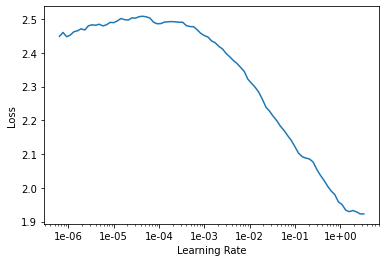

In [134]:
learn.recorder.plot()

In [135]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.281908,0.179831,0.950600,00:10
1,0.156221,0.113069,0.964200,00:10
2,0.075067,0.033256,0.990600,00:10


### ResBlock basic implementation

In [172]:
class ResBlock_same(nn.Module):
    def __init__(self, nf, s=1):
        super().__init__()
        self.conv1 = seq_conv_bn_relu(nf, nf, s)
        self.conv2 = seq_conv_bn_relu(nf, nf, s)
        
    def forward(self, xi):
        x = self.conv1(xi)
        x = self.conv2(x)
        x = xi + x
        return x

In [173]:
ResBlock_same(16)

ResBlock_same(
  (conv1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [206]:
def conv_res(ni, nf, stride=2):
    return nn.Sequential(
        conv2d(ni, nf, stride = stride),
        ResBlock_same(nf)
    )

In [207]:
conv_res(16, 32)

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ResBlock_same(
    (conv1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
)

In [194]:
class BasicResNet(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.res1 = conv_res(1, 16)
        self.res2 = conv_res(16, 32)
        self.res3 = conv_res(32, 64)
        self.res4 = conv_res(64, 32)
        self.conv_last = conv2d(32, 10, stride=2)
        self.flat = nn.Flatten()
        
    def forward(self, xb):
        xb = self.res1(xb)
        xb = self.res2(xb)
        xb = self.res3(xb)
        xb = self.res4(xb)
        xb = self.conv_last(xb)
        xb = self.flat(xb)
        return xb

In [195]:
model = BasicResNet(1, 10)

In [196]:
model

BasicResNet(
  (res1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_same(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (res2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_same(
      (conv1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
   

In [197]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [198]:
learn.summary()

BasicResNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         144        True      
______________________________________________________________________
Conv2d               [16, 14, 14]         2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [16, 14, 14]         2,304      True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
__________________________________________________

In [199]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


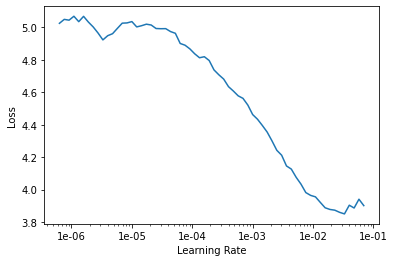

In [200]:
learn.recorder.plot()

In [201]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.224933,0.151358,0.957600,00:16
1,0.080167,0.049100,0.984100,00:16
2,0.026366,0.019266,0.993300,00:16


In [208]:
class ResBlock_up(nn.Module):
    def __init__(self, ni, nu, s=1):
        super().__init__()
        self.conv1 = seq_conv_bn_relu(ni, nu, s)
        self.conv2 = seq_conv_bn_relu(nu, ni, s)
        
    def forward(self, xi):
        x = self.conv1(xi)
        x = self.conv2(x)
        x = xi + x
        return x

In [209]:
def conv_res_u(ni, nf, nu, stride=2):
    return nn.Sequential(
        conv2d(ni, nf, stride = stride),
        ResBlock_up(nf, nu)
    )

In [211]:
conv_res_u(16, 32, 64)

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ResBlock_up(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
)

In [216]:
class BasicResNet_u(nn.Module):
    def __init__(self, ni, no):
        super().__init__()
        self.res1 = conv_res_u(1, 16, 32)
        self.res2 = conv_res_u(16, 32, 64)
        self.res3 = conv_res_u(32, 64, 128)
        self.res4 = conv_res_u(64, 32, 32)
        self.conv_last = conv2d(32, 10, stride=2)
        self.flat = nn.Flatten()
        
    def forward(self, xb):
        xb = self.res1(xb)
        xb = self.res2(xb)
        xb = self.res3(xb)
        xb = self.res4(xb)
        xb = self.conv_last(xb)
        xb = self.flat(xb)
        return xb

In [217]:
model = BasicResNet_u(1, 10)

In [218]:
model

BasicResNet_u(
  (res1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_up(
      (conv1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (res2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ResBlock_up(
      (conv1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
     

In [219]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [220]:
learn.summary()

BasicResNet_u
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 14, 14]         144        True      
______________________________________________________________________
Conv2d               [32, 14, 14]         4,608      True      
______________________________________________________________________
BatchNorm2d          [32, 14, 14]         64         True      
______________________________________________________________________
ReLU                 [32, 14, 14]         0          False     
______________________________________________________________________
Conv2d               [16, 14, 14]         4,608      True      
______________________________________________________________________
BatchNorm2d          [16, 14, 14]         32         True      
______________________________________________________________________
ReLU                 [16, 14, 14]         0          False     
________________________________________________

In [221]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


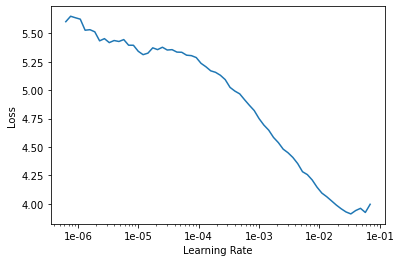

In [222]:
learn.recorder.plot()

In [223]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.202829,0.138683,0.958200,00:16
1,0.074992,0.050552,0.983500,00:16
2,0.034707,0.018814,0.993600,00:16


In [227]:
learn.fit_one_cycle(8, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.028007,0.013828,0.995000,00:16
1,0.015962,0.012486,0.996100,00:16
2,0.008711,0.012786,0.995800,00:16
3,0.008143,0.012854,0.995100,00:16
4,0.015609,0.012141,0.995800,00:16
5,0.008326,0.012162,0.995700,00:16
6,0.004130,0.012209,0.995900,00:16
7,0.006523,0.012343,0.995700,00:16
